# Utility functions

In [1]:
from datasets.molecules.utils import smiles2graph
from GRALE.data import BatchedDenseData
import torch
from GRALE.vizualization.plots import graph_to_mol, graph_to_smiles
from GRALE.main import GRALE_model
import json
from rdkit import Chem
from huggingface_hub import hf_hub_download

def check_valid_smiles(smiles, config):
    n_max_nodes = config['n_max_nodes']
    valid_atomic_nums = config['valid_atomic_nums']
    valid_bond_types = config['valid_bond_types']
    graph = smiles2graph(smiles,n_max_nodes,valid_atomic_nums,valid_bond_types)
    if graph is None:
        return False
    return True

def smiles_to_data(smiles_list, config, device='cuda'):
    '''
    Convert a smiles list to a BatchedDenseData object.
    A BatchedDenseData object contains:
        - h: node mask (batch_size, n_max_nodes)
        - nodes.labels: node labels (batch_size, n_max_nodes, n_node_labels)
        - edges.adjacency: edge adjacency (batch_size, n_max_nodes, n_max_nodes)
        - edges.labels: edge labels (batch_size, n_max_nodes, n_max_nodes, n_edge_labels)
        - edges.SP: shortest path matrix (batch_size, n_max_nodes, n_max_nodes)
    '''
    n_max_nodes = config['n_max_nodes']
    valid_atomic_nums = config['valid_atomic_nums']
    n_node_labels = len(valid_atomic_nums)
    valid_bond_types = config['valid_bond_types']
    n_edge_labels= len(valid_bond_types)
    graphs = [smiles2graph(smiles,n_max_nodes,valid_atomic_nums,valid_bond_types) for smiles in smiles_list]
    h = torch.stack([~torch.tensor(graph['node_mask'],dtype=torch.bool,device=device) for graph in graphs])
    node_labels =  torch.stack([torch.nn.functional.one_hot(torch.tensor(graph['node_labels'], dtype=torch.long, device=device), num_classes=n_node_labels).to(torch.float32) for graph in graphs])
    edge_labels = torch.stack([torch.nn.functional.one_hot(torch.tensor(graph['edge_labels'], dtype=torch.long, device=device), num_classes=n_edge_labels).to(torch.float32) for graph in graphs])
    adjacency = torch.stack([torch.tensor(graph['edge_labels']>0, device=device, dtype=torch.float32) for graph in graphs])
    SP_matrix = torch.stack([torch.tensor(graph['SP_matrix'], device=device, dtype=torch.float32) for graph in graphs])
    data = BatchedDenseData(h=h, nodes={'labels': node_labels}, edges={'adjacency': adjacency, 'labels': edge_labels, 'SP': SP_matrix})
    return data

def data_to_smiles(batched_data, config):
    smiles_list = []
    for data in batched_data:
        h = data.h
        active = h > 0.5
        node_labels = data.nodes.labels[active].cpu().detach().numpy().argmax(-1)
        node_edges = data.edges.labels[active][:,active].cpu().detach().numpy().argmax(-1)
        smiles = graph_to_smiles(node_labels, node_edges)
        smiles_list.append(smiles)
    return smiles_list

def data_to_mol(batched_data, config, sanitize=False):
    mol_list = []
    for data in batched_data:
        h = data.h
        active = h > 0.5
        node_labels = data.nodes.labels[active].cpu().detach().numpy().argmax(-1)
        node_edges = data.edges.labels[active][:,active].cpu().detach().numpy().argmax(-1)
        mol = graph_to_mol(node_labels, node_edges, sanitize=sanitize)
        mol_list.append(mol)
    return mol_list

def load_model(device='cuda'):
    out = hf_hub_download(repo_id="PaulKrzakala/GRALE-128-32", filename="last.ckpt")
    model = GRALE_model.load_from_checkpoint(out).to(device)
    config = json.load(open('datasets/molecules/configs/32.json','r'))
    return model, config

def accuracy(smiles_true, smiles_pred):
    correct = 0
    for s_true, s_pred in zip(smiles_true, smiles_pred):
        s_true_canonical = Chem.CanonSmiles(s_true)
        s_pred_canonical = Chem.CanonSmiles(s_pred)
        if s_true_canonical == s_pred_canonical:
            correct += 1
    return correct / len(smiles_true)


# Compute Reconstruction Accuracy

In [2]:
from rdkit.Chem import MolFromSmiles, MolToSmiles

device="cuda"
# Load Model
model, config = load_model(device=device)
# Get SMILES strings
smiles_list = ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CC(=O)Oc1ccccc1C(=O)O', 'CC(O)C(=O)O']
# Convert to BatchedDenseData format
data = smiles_to_data(smiles_list, config, device=device)
# Encode and Decode
latent = model.encode(data)
output = model.decode(latent)
# Convert back to SMILES
smiles_out = data_to_smiles(output, config)
# Compute reconstruction accuracy
print(f"Reconstruction accuracy: {accuracy(smiles_list, smiles_out):.2%}")

Reconstruction accuracy: 100.00%


# Plot Reconstruction (2D)

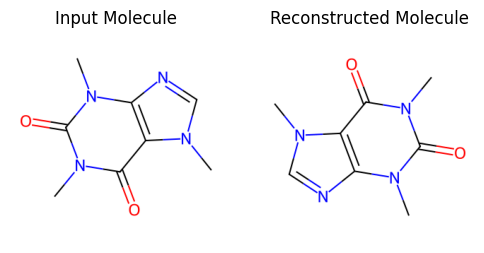

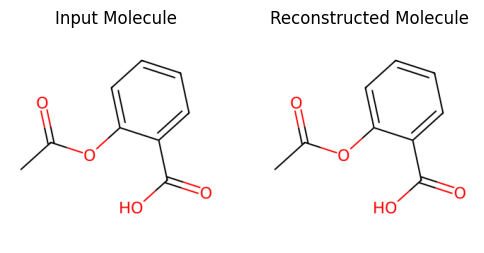

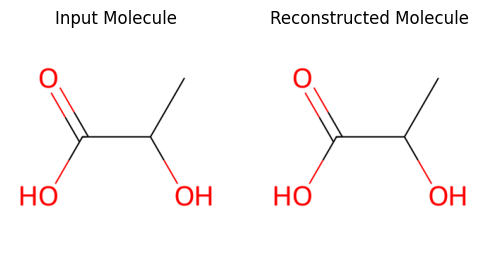

In [3]:
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Load Model
model, config = load_model()
# Get SMILES strings
smiles_list = ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CC(=O)Oc1ccccc1C(=O)O', 'CC(O)C(=O)O']
# Convert to BatchedDenseData format
data = smiles_to_data(smiles_list, config)
# Encode and Decode
latent = model.encode(data)
output = model.decode(latent)
smiles_out = data_to_smiles(output, config)

for smi_in, smi_out in zip(smiles_list, smiles_out):
    mol_in = MolFromSmiles(smi_in)
    mol_out = MolFromSmiles(smi_out)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(Draw.MolToImage(mol_in))
    axes[0].set_title('Input Molecule')
    axes[0].axis('off')
    axes[1].imshow(Draw.MolToImage(mol_out))
    axes[1].set_title('Reconstructed Molecule')
    axes[1].axis('off')
    plt.show()

# PCA

In [4]:
import os 
import pandas as pd

n_samples = 10000

url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
path = "data/raw/qm9.csv"
if not os.path.exists(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    qm9_data = pd.read_csv(url)
    qm9_data.to_csv(path, index=False)
else:
    qm9_data = pd.read_csv(path)
    
frac = n_samples / len(qm9_data)
qm9_subset = qm9_data.sample(frac=frac, random_state=42).reset_index(drop=True)  # Shuffle the dataset

target_name = 'n_nodes'
def compute_size(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol is not None else 0
qm9_subset['n_nodes'] = qm9_subset['smiles'].apply(compute_size)

target_name = 'n_edges'
def compute_num_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumBonds() if mol is not None else 0
qm9_subset['n_edges'] = qm9_subset['smiles'].apply(compute_num_bonds)

print(qm9_subset.shape)
print(qm9_subset.columns)

(10000, 23)
Index(['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom',
       'u298_atom', 'h298_atom', 'g298_atom', 'n_nodes', 'n_edges'],
      dtype='object')


In [5]:
import numpy as np

qm9_embeddings = []
batch_size = 64
for i in range(0, len(qm9_subset), batch_size):
    smiles_batch = qm9_subset['smiles'][i:i+batch_size].tolist()
    data_batch = smiles_to_data(smiles_batch, config, device=device)
    with torch.no_grad():
        latent_batch = model.encode(data_batch)
    qm9_embeddings.append(latent_batch.cpu().squeeze().numpy())
qm9_embeddings = np.concatenate(qm9_embeddings, axis=0)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = qm9_embeddings
X = StandardScaler().fit_transform(X)

X_pca = pca_pubchem.transform(X)

tsne_50 = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne_50 = tsne_50.fit_transform(X)

In [40]:
tsne_100 = TSNE(n_components=2, random_state=42, perplexity=100)
X_tsne_100 = tsne_100.fit_transform(X)

In [36]:
qm9_subset.columns.to_list()

['mol_id',
 'smiles',
 'A',
 'B',
 'C',
 'mu',
 'alpha',
 'homo',
 'lumo',
 'gap',
 'r2',
 'zpve',
 'u0',
 'u298',
 'h298',
 'g298',
 'cv',
 'u0_atom',
 'u298_atom',
 'h298_atom',
 'g298_atom',
 'n_nodes',
 'n_edges']

In [ ]:
color_map = 'coolwarm'
samples = -1
alpha = 0.8
scale = 2.5

for target_name in ['u0', 'alpha', 'zpve', 'homo','lumo', 'r2', 'u298_atom', 'h298_atom', 'g298_atom']:
    target_values = np.array(qm9_subset[target_name].values, dtype=np.float32)
    vmin = -2
    vmax = 2
    normalize = True
    y = target_values
    if normalize:
        y = StandardScaler().fit_transform(y.reshape(-1, 1)).squeeze()
        
    fig,ax = plt.subplots(figsize=(10/scale,8/scale))
    scatter = ax.scatter(X_tsne_50[:samples,0], X_tsne_50[:samples,1], c=y[:samples], s=30/scale, cmap=color_map, alpha=alpha, edgecolor='black', linewidth=0.1, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(scatter)
    #cbar.set_label(f"{target_name} (normalized)")
    plt.title(f'{target_name}')
    #ax.set_xlabel('T-SNE Component 1')
    #ax.set_ylabel('T-SNE Component 2')
    ax.axis('off')
    plt.savefig(f'data/plots/qm9_tsne_{target_name}.png', dpi=1200, bbox_inches='tight')
    plt.show()
    
    '''
    fig,ax = plt.subplots(figsize=(10/scale,8/scale))
    scatter = ax.scatter(X_pca[:samples,0], X_pca[:samples,1], c=y[:samples], s=30/scale, cmap=color_map, alpha=alpha, edgecolor='black', linewidth=0.1, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Internal Energy U0 (normalized)")
    plt.title('PCA (QM9)')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    plt.savefig('data/plots/qm9_pca_u0.png', dpi=1200, bbox_inches='tight')
    plt.show()
    '''

# PCA PUBCHEM

In [75]:
chunk_iter = pd.read_csv('data/raw/PUBCHEM.csv', chunksize=10000, sep='\t', index_col=0, header=None)
smiles = next(chunk_iter)[1].tolist()
smiles = [smi for smi in smiles if check_valid_smiles(smi, config)]

In [76]:
from rdkit.Chem.Descriptors import MolLogP

def compute_size(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol is not None else 0
n_nodes = np.array([compute_size(smi) for smi in smiles])

def compute_num_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumBonds() if mol is not None else 0
n_edges = np.array([compute_num_bonds(smi) for smi in smiles])

def compute_n_carbons(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0
    count = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            count += 1
    return count
n_carbons = np.array([compute_n_carbons(smi) for smi in smiles])
carbons_ratio = [n_c / n_n if n_n > 0 else 0 for n_c, n_n in zip(n_carbons, n_nodes)]

def compute_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return MolLogP(mol) if mol is not None else 0
logp = [compute_logp(smi) for smi in smiles]

In [77]:
import numpy as np

embeddings = []
batch_size = 64
for i in range(0, len(smiles), batch_size):
    smiles_batch = smiles[i:i+batch_size]
    data_batch = smiles_to_data(smiles_batch, config, device=device)
    with torch.no_grad():
        latent_batch = model.encode(data_batch)
    embeddings.append(latent_batch.cpu().squeeze().numpy())
embeddings = np.concatenate(embeddings, axis=0)

In [78]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = embeddings
X = StandardScaler().fit_transform(X)

pca_pubchem = PCA(n_components=2)
X_pca_2 = pca_pubchem.fit_transform(X)

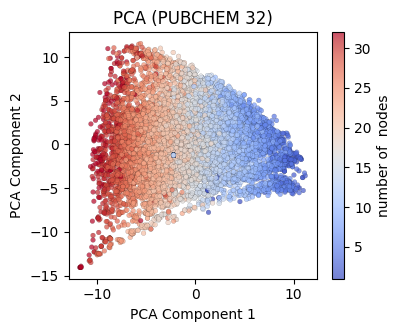

In [79]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

color_map = 'coolwarm'
samples = -1
alpha = 0.7
scale = 2.5

target = n_nodes 
target = np.array(target, dtype=np.float32)
vmin = None
vmax = 32
fig,ax = plt.subplots(figsize=(10/scale,8/scale))
scatter = ax.scatter(X_pca_2[:samples,0], X_pca_2[:samples,1], c=target[:samples], s=30/scale, cmap=color_map, alpha=alpha, edgecolor='black', linewidth=0.1, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatter)
cbar.set_label("number of  nodes")
plt.title('PCA (PUBCHEM 32)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.savefig('data/plots/pubchem_pca_n_nodes.png', dpi=1200, bbox_inches='tight')
plt.show()

In [80]:
# Get the top-k molecules along PCA directions
k = 8
pca_components = pca_pubchem.components_
topk_indices = {}
for i in [0,1]:
    component = pca_components[i]
    projections = X.dot(component)
    topk_pos_indices = np.argsort(projections)[-k:]
    topk_neg_indices = np.argsort(projections)[:k]
    topk_indices[f'PCA_Component_{i+1}_Positive'] = [smiles[idx] for idx in topk_pos_indices]
    topk_indices[f'PCA_Component_{i+1}_Negative'] = [smiles[idx] for idx in topk_neg_indices]

In [81]:
topk_indices

{'PCA_Component_1_Positive': ['CNN',
  'C#N',
  '[C-]#N',
  'NO',
  '[NH3+]O',
  'CCl',
  '[N-]=[N+]=O',
  'N=O'],
 'PCA_Component_1_Negative': ['C1=CC=C2C=C3C4=C5C(=CC3=CC2=C1)C=CC6=CC7=CC8=CC=CC=C8C=C7C(=C65)C=C4',
  'C1=CC=C2C=C3C4=C5C(=CC3=CC2=C1)C=CC6=C5C(=CC7=CC8=CC=CC=C8C=C67)C=C4',
  'C1=CC=C2C=C3C4=C5C(=CC=C4)C6=CC7=CC=CC=C7C=C6C8=CC=CC(=C85)C3=CC2=C1',
  'C1=CC=C2C=C3C=C4C=C5C6=C7C(=CC5=CC4=CC3=CC2=C1)C=CC8=C7C(=CC=C8)C=C6',
  'C1=CC=C2C=C3C=C4C5=CC=CC6=C5C7=C(C=CC=C7C4=CC3=CC2=C1)C8=CC=CC=C68',
  'C1=CC=C2C=C3C=C4C=C5C6=CC=CC7=C6C8=C(C=CC=C8C5=CC4=CC3=CC2=C1)C=C7',
  'CC(CCC=C(C)C)C1(CCC2(C1(CCC3=C2CCC4C3(CCC(C4(C)C)O)C)C)C)C',
  'CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C'],
 'PCA_Component_2_Positive': ['C(COCCOCCOCCOCCOCCOCCOCCOCCO)O',
  'CN1C2=C(C(=O)N(C1=O)C)NC=N2.CN1C2=C(C(=O)N(C1=O)C)NC=N2.C(CN)N',
  'C1=CN2C=NC3=C(C2=N1)N=CN3C4C(C(C(O4)COP(=O)(O)OP(=O)(O)O)O)O',
  'C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OC(=O)C(CC(=O)O)N)O)O)N',
  'C[N+](C)(C)CCOP(=O)(O)OP(=O)(O)

CNN
C#N
[C-]#N
NO
[NH3+]O
CCl
[N-]=[N+]=O
N=O


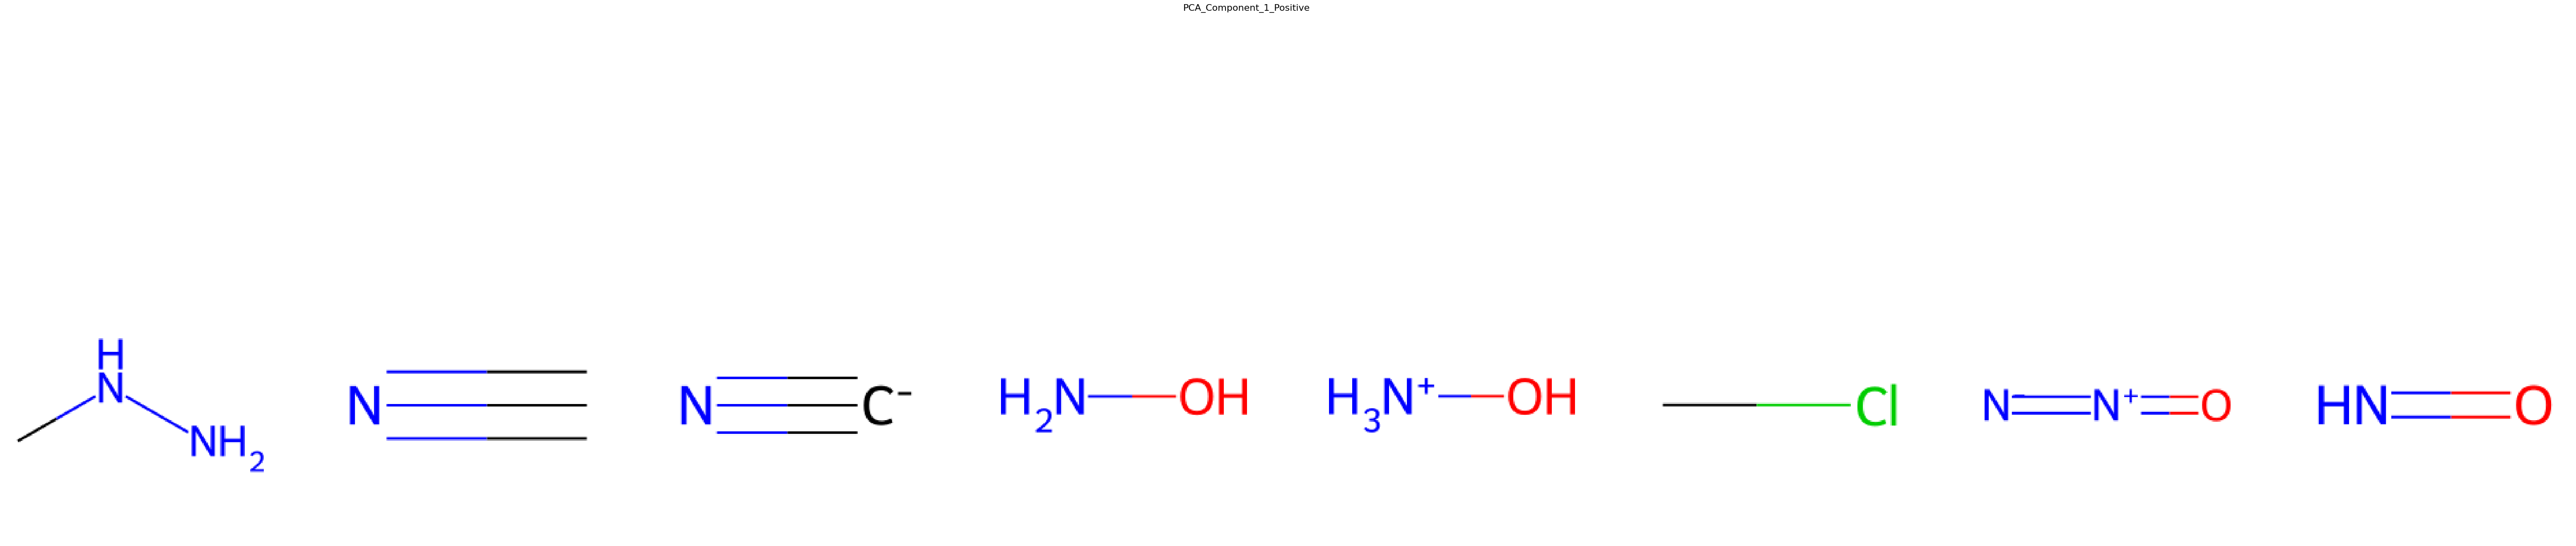

C1=CC=C2C=C3C4=C5C(=CC3=CC2=C1)C=CC6=CC7=CC8=CC=CC=C8C=C7C(=C65)C=C4
C1=CC=C2C=C3C4=C5C(=CC3=CC2=C1)C=CC6=C5C(=CC7=CC8=CC=CC=C8C=C67)C=C4
C1=CC=C2C=C3C4=C5C(=CC=C4)C6=CC7=CC=CC=C7C=C6C8=CC=CC(=C85)C3=CC2=C1
C1=CC=C2C=C3C=C4C=C5C6=C7C(=CC5=CC4=CC3=CC2=C1)C=CC8=C7C(=CC=C8)C=C6
C1=CC=C2C=C3C=C4C5=CC=CC6=C5C7=C(C=CC=C7C4=CC3=CC2=C1)C8=CC=CC=C68
C1=CC=C2C=C3C=C4C=C5C6=CC=CC7=C6C8=C(C=CC=C8C5=CC4=CC3=CC2=C1)C=C7
CC(CCC=C(C)C)C1(CCC2(C1(CCC3=C2CCC4C3(CCC(C4(C)C)O)C)C)C)C
CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C


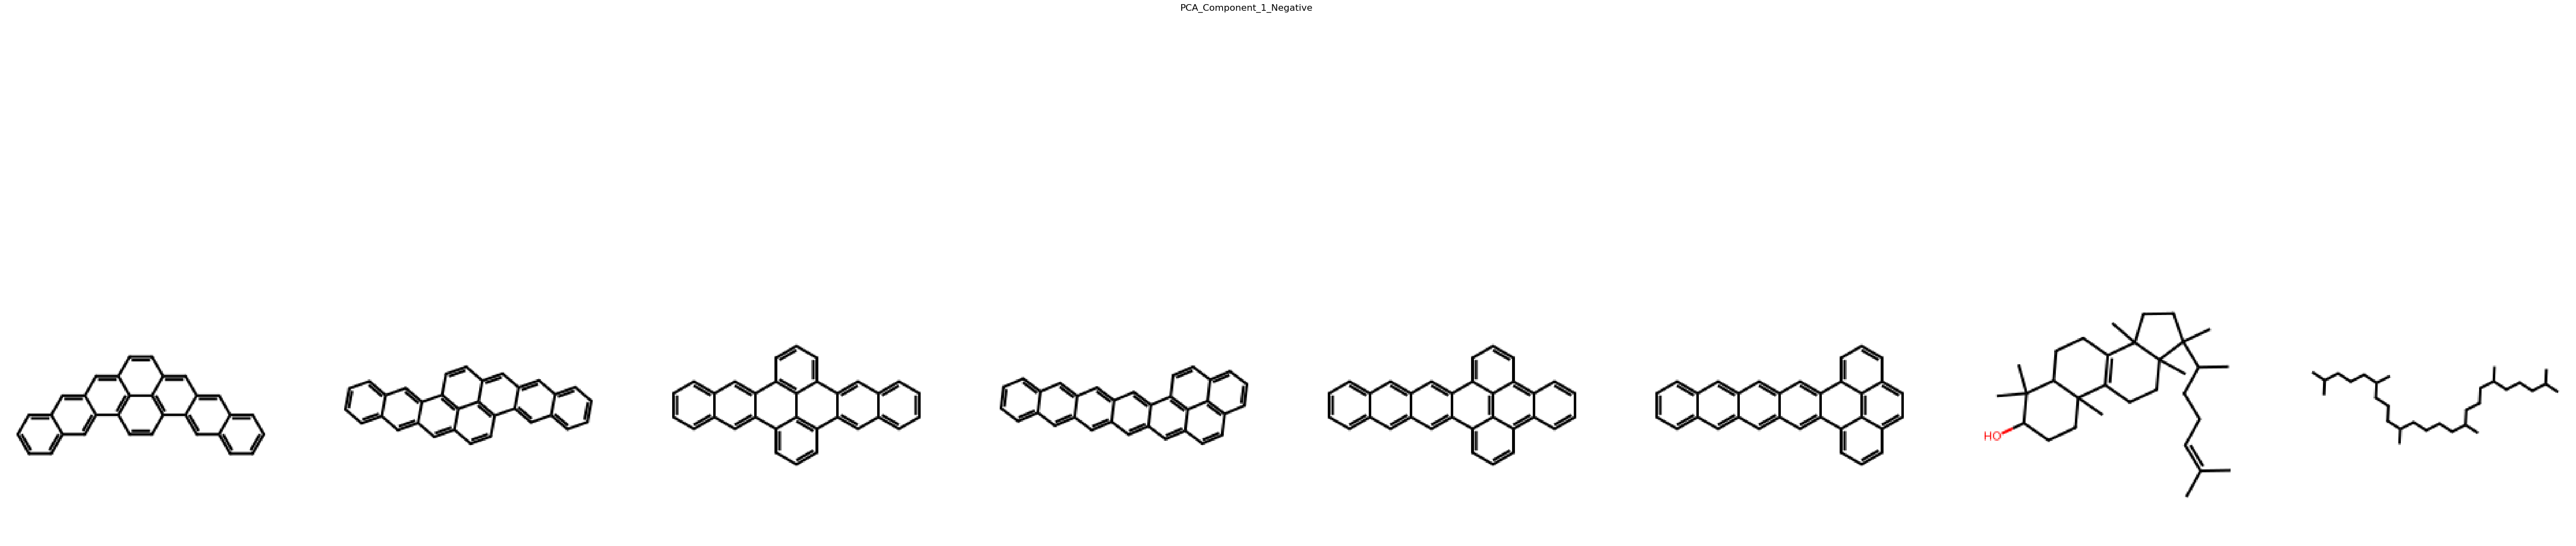

C(COCCOCCOCCOCCOCCOCCOCCOCCO)O
CN1C2=C(C(=O)N(C1=O)C)NC=N2.CN1C2=C(C(=O)N(C1=O)C)NC=N2.C(CN)N
C1=CN2C=NC3=C(C2=N1)N=CN3C4C(C(C(O4)COP(=O)(O)OP(=O)(O)O)O)O
C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OC(=O)C(CC(=O)O)N)O)O)N
C[N+](C)(C)CCOP(=O)(O)OP(=O)(O)OCC1(COC(C1O)N2C=CC(=NC2=O)N)O
C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O)O)NC(CC(=O)O)C(=O)O
C(CN(CC(=O)O)CC(=O)O)N(CCN(CC(=O)O)CC(=O)O)CC(=O)O
C(COCCOCCN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O


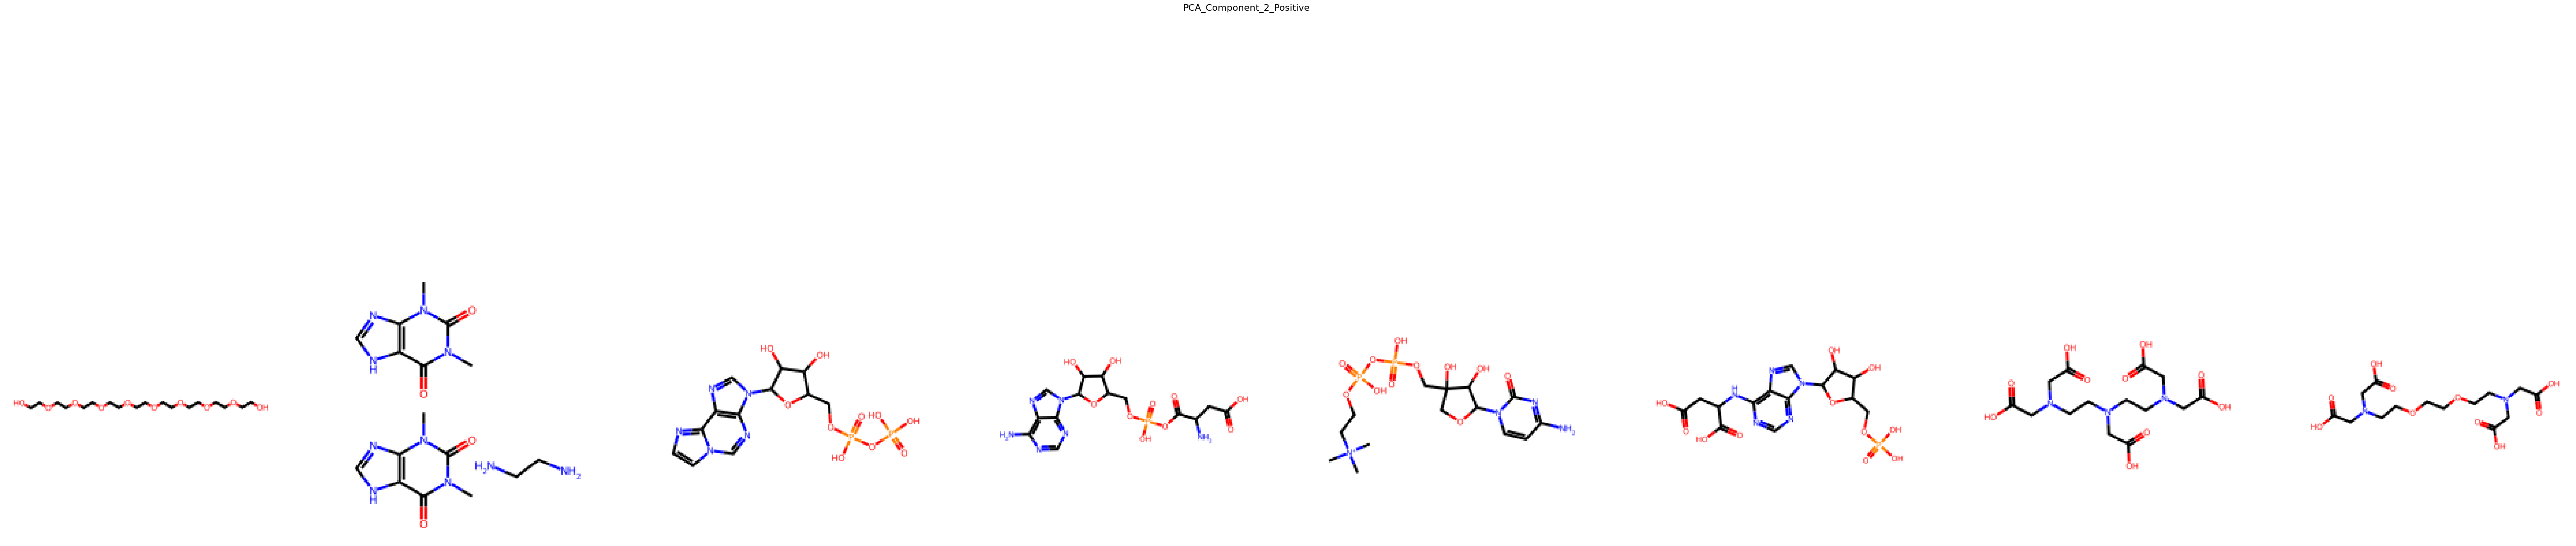

C1=CC=C2C=C3C=C4C5=CC=CC6=C5C7=C(C=CC=C7C4=CC3=CC2=C1)C8=CC=CC=C68
C1=CC=C2C=C3C4=C5C(=CC3=CC2=C1)C=CC6=C5C(=CC7=CC8=CC=CC=C8C=C67)C=C4
C1=CC=C2C=C3C4=C5C(=CC3=CC2=C1)C=CC6=CC7=CC8=CC=CC=C8C=C7C(=C65)C=C4
C1=CC=C2C=C3C4=C5C(=CC=C4)C6=CC7=CC=CC=C7C=C6C8=CC=CC(=C85)C3=CC2=C1
C1=CC=C2C=C3C=C4C=C5C6=CC=CC7=C6C8=C(C=CC=C8C5=CC4=CC3=CC2=C1)C=C7
C1=CC=C2C=C3C=C4C=C5C6=C7C(=CC5=CC4=CC3=CC2=C1)C=CC8=C7C(=CC=C8)C=C6
C1=CC2=C3C(=C1)C4=C(C5=CC=CC(=C53)C=C2)C6=CC=CC7=C6C8=C(C=CC=C84)C=C7
CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C


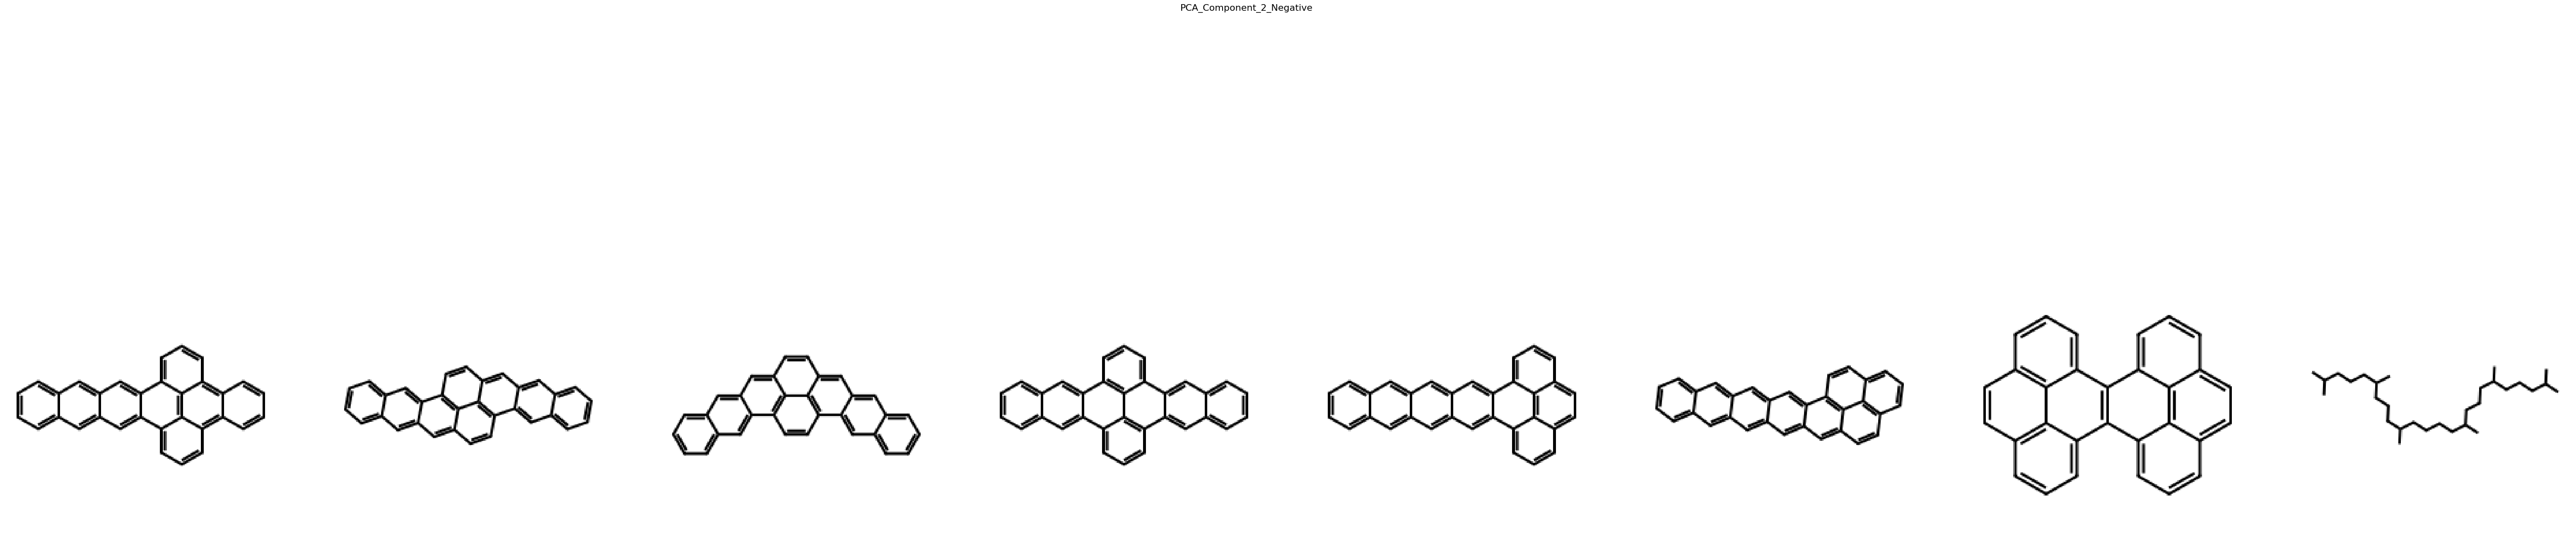

In [82]:
for name, smi_list in topk_indices.items():
    fig, axes = plt.subplots(1, k, figsize=(k*10, 20))
    fig.suptitle(name, fontsize=16)
    for ax, smi in zip(axes, smi_list):
        mol = Chem.MolFromSmiles(smi)
        img = Draw.MolToImage(mol, size=(200, 200))
        print(smi)
        ax.imshow(img)
        ax.axis('off')
    plt.show()
        
        

In [91]:
for smiles in topk_indices['PCA_Component_2_Negative']:
    mol = Chem.MolFromSmiles(smiles)
    s = 300
    d = Draw.rdMolDraw2D.MolDraw2DCairo(s,s)
    dopts = d.drawOptions()
    # dopts.maxFontSize=40
    # dopts.minFontSize=40
    dopts.maxFontSize=int(0.10*s)
    dopts.minFontSize=int(0.10*s)
    dopts.bondLineWidth=(0.010*s)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    png = d.GetDrawingText()
    with open(f'data/plots/topk_pca2_negative_{smiles}.png', 'wb') as f:
        f.write(png)

In [92]:
for smiles in topk_indices['PCA_Component_2_Positive']:
    mol = Chem.MolFromSmiles(smiles)
    s = 300
    d = Draw.rdMolDraw2D.MolDraw2DCairo(s,s)
    dopts = d.drawOptions()
    # dopts.maxFontSize=40
    # dopts.minFontSize=40
    dopts.maxFontSize=int(0.05*s)
    dopts.minFontSize=int(0.05*s)
    dopts.bondLineWidth=(0.008*s)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    png = d.GetDrawingText()
    with open(f'data/plots/topk_pca2_positive_{smiles}.png', 'wb') as f:
        f.write(png)

In [ ]:
for smiles in topk_indices['PCA_Component_2_Positive']:
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, size=(600, 600))
    img.save(f'data/plots/{smiles}.png')
    

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

# COLORING

In [46]:
import torch
torch.set_printoptions(precision=1, sci_mode=False)
device = 'cuda'
run_name = 'coloring_big_base_2'
from GRALE.main import GRALE_model
import torch
# Load a Lightning checkpoint
checkpoint_path = f"checkpoints/{run_name}/last.ckpt"
model = GRALE_model.load_from_checkpoint(checkpoint_path)
model = model.to(device)
model = model.eval()
config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage, weights_only=False)["hyper_parameters"]
# Load data
from GRALE.data.dataset import DataModule
path_h5 = 'data/h5/COLORING_plots.h5'
datamodule = DataModule(
    path_h5=path_h5,
    batch_size=32,
    n_data_epoch=10000,
    n_data_valid=1000,
    n_workers=4,
)
loader = datamodule.train_dataloader()

---
The full train dataset is of size 10000.
Every epoch a chunk of size 10000 is loaded.
The entire dataset will be iterated every 1.0 epochs.
Consider using fully loading the data for better efficiency.
---
Loading only 1000 samples of the valid dataset in memory.
---


In [47]:
all_embeddings = []
all_sizes = []
for inputs in loader:
    inputs = inputs.to(device)
    z = model.encode(inputs)
    all_embeddings.append(z.cpu().detach().flatten(1))
    all_sizes.append(inputs.h.sum(-1).cpu().detach())

all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
all_sizes = torch.cat(all_sizes, dim=0).numpy()

In [48]:
all_sizes.max()

np.int64(20)

In [52]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = all_embeddings
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

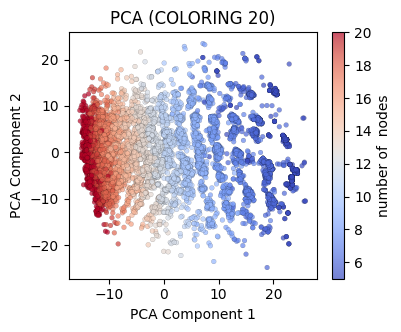

In [77]:
import matplotlib.pyplot as plt
import numpy as np

color_map = 'coolwarm'
samples = -1
alpha = 0.7
scale = 2.5

target = all_sizes 
target = np.array(target, dtype=np.float32)
vmin = 5
vmax = 20
fig,ax = plt.subplots(figsize=(10/scale,8/scale))
scatter = ax.scatter(X_pca[:samples,0], X_pca[:samples,1], c=target[:samples], s=30/scale, cmap=color_map, alpha=alpha, edgecolor='black', linewidth=0.1, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatter)
cbar.set_label("number of  nodes")
plt.title('PCA (COLORING 20)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.savefig('data/plots/coloring_pca_n_nodes.png', dpi=1200, bbox_inches='tight')
plt.show()

In [55]:
# Get the top-k molecules along PCA directions
k = 8
pca_components = pca.components_
topk_indices = {}
for i in [0,1]:
    component = pca_components[i]
    projections = X.dot(component)
    topk_pos_indices = np.argsort(projections)[-k:]
    topk_neg_indices = np.argsort(projections)[:k]
    topk_indices[f'PCA_Component_{i+1}_Positive'] = topk_pos_indices
    topk_indices[f'PCA_Component_{i+1}_Negative'] = topk_neg_indices

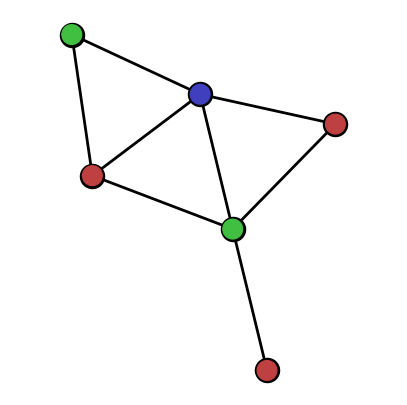

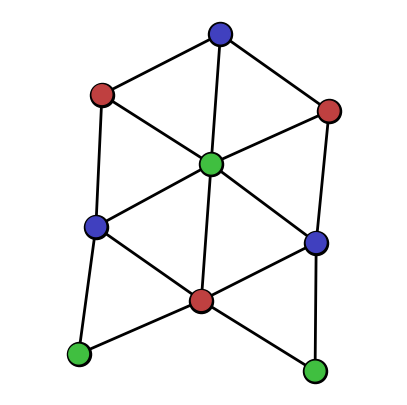

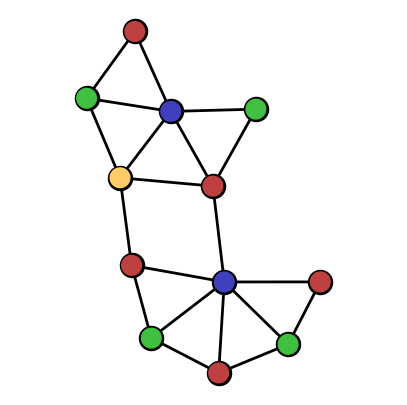

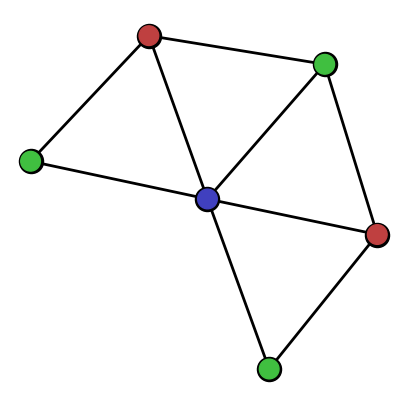

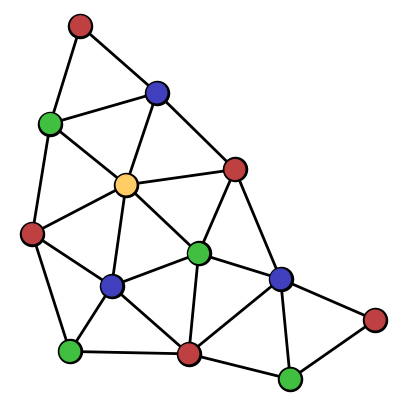

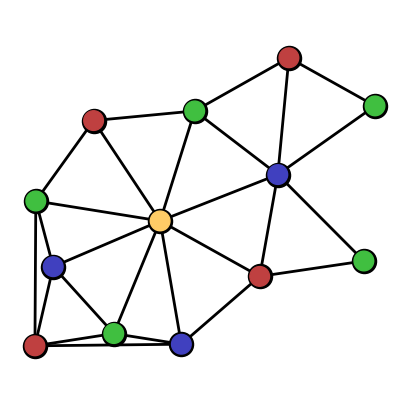

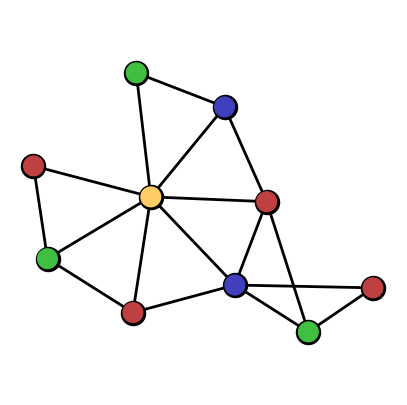

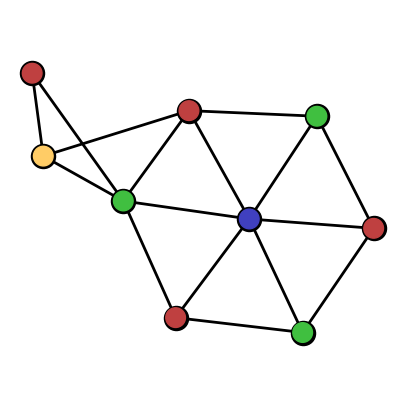

In [76]:
from GRALE.vizualization.plots import plot_graph 

frame = False
edge_weight = False

for i in topk_indices['PCA_Component_2_Negative']:
    embeddings = all_embeddings[i:i+1]
    embeddings = embeddings.reshape(1, 4, 128)
    output = model.decode(torch.tensor(embeddings, device=device))
    h = output.h.cpu().detach().numpy()[0]
    active = h > 0.5
    F = output.nodes['labels'].cpu().detach().numpy()[0][active, :]
    A = output.edges['adjacency'].cpu().detach().numpy()[0][active][:,active]
    fig, (ax1) = plt.subplots(1, figsize=(5,5))
    pos = 'kamada'
    pos = plot_graph(F,A,ax=ax1,pos=pos,frame=frame,edge_weight=edge_weight,colors=None)
    plt.show()
